In [1]:
import torch
import torch.nn as nn
from transformers import AutoImageProcessor, AutoModel
from torch.amp import autocast
import torchvision.transforms as T
import warnings 
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torchvision.models as models
import timm

class ResNet18(nn.Module):
    def __init__(self, num_classes, device='cuda',seed=0):
        super().__init__()
        self.device = device
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        self.model = models.resnet18(pretrained=False)
        self.model.fc = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.model.fc.in_features, num_classes)
        )
        self.model.to(device)
    def forward(self, x):
        return self.model(x)

class EfficientNet(nn.Module):
    def __init__(self, num_classes, device='cuda',seed=0):
        super().__init__()
        self.device = device
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        self.model = timm.create_model('efficientnet_b0', pretrained=False)
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.model.classifier.in_features, num_classes)
        )
        self.model.to(device)
    def forward(self, x):
        return self.model(x)

class VisionTransformer(nn.Module):
    def __init__(self, num_classes, device='cuda',seed=0):
        super().__init__()
        self.device = device
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        self.model = timm.create_model('vit_base_patch16_224', pretrained=False)
        self.model.head = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.model.head.in_features, num_classes)
        )
        self.model.to(device)
    def forward(self, x):
        return self.model(x)

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import gc
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

class WeatherDataset(Dataset):
    def __init__(self, root_dir, classes, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = classes
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        self.images = []
        self.labels = []
        
        # Collect all images and labels
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                self.images.append(os.path.join(class_dir, img_name))
                self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image =  Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        return image, label

def get_dataloaders(data_dir, batch_size=32):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    classes = [i for i in os.listdir(data_dir)]
    dataset = WeatherDataset(data_dir, classes, transform=transform)
    
    # Split indices: 70% train, 15% val, 15% test
    train_size = 0.7
    val_size = 0.15
    test_size = 0.15
    
    # First split into train and temp
    train_idx, temp_idx = train_test_split(
        range(len(dataset)),
        test_size=(val_size + test_size),
        stratify=dataset.labels,
        random_state=42
    )
    
    # Split temp into val and test
    rel_val_size = val_size / (val_size + test_size)
    val_idx, test_idx = train_test_split(
        temp_idx,
        test_size=0.5,  # 50% of temp goes to test
        stratify=[dataset.labels[i] for i in temp_idx],
        random_state=42
    )
    
    # Create samplers
    train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)
    test_sampler = torch.utils.data.SubsetRandomSampler(test_idx)
    
    # Create loaders
    train_loader = DataLoader(
        dataset, 
        batch_size=batch_size,
        sampler=train_sampler,
        num_workers=4,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        sampler=val_sampler,
        num_workers=4,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        sampler=test_sampler,
        num_workers=4,
        pin_memory=True
    )
    return train_loader, val_loader, test_loader, len(classes)


In [3]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0, path='best_model.pth'):
        self.patience = patience
        self.delta = delta
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        print(f'Validation loss improved ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


def train_model(model, train_loader, val_loader, num_epochs=100, patience=5,checkpoint_path = 'best_model.pth'):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    scaler = torch.cuda.amp.GradScaler()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

    early_stopping = EarlyStopping(patience=patience, path=checkpoint_path)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in tqdm(train_loader):
            torch.cuda.empty_cache()
            gc.collect()
            images, labels = images.to(model.device), labels.to(model.device)
            optimizer.zero_grad()

            with autocast(model.device):
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        print(f'Epoch {epoch}, Average Training Loss: {avg_train_loss:.4f}')

        # Validation
        model.eval()
        correct = 0
        total = 0
        val_loss = 0.0

        with torch.no_grad():
            for images, labels in tqdm(val_loader):
                torch.cuda.empty_cache()
                gc.collect()
                images = images.to(model.device)
                labels = labels.to(model.device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_acc = 100. * correct / total
        print(f'Epoch: {epoch}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')

        # Step the scheduler
        scheduler.step(avg_val_loss)

        # Early Stopping
        early_stopping(avg_val_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

    # Load the best model
    model.load_state_dict(torch.load('best_model.pth'))

def evaluate_model(model, test_loader, device='cuda'):
    model.eval()
    
    # Lists to store predictions and ground truth
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            
            # Store predictions and labels
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Convert to numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, 
                                                             all_predictions, 
                                                             average='weighted')
    
    # Calculate per-class metrics
    class_precision, class_recall, class_f1, _ = precision_recall_fscore_support(all_labels, 
                                                                               all_predictions, 
                                                                               average=None)
    
    # Get class names from test_loader
    class_names = test_loader.dataset.classes
    
    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    
    # Print overall metrics
    print("\nOverall Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Print per-class metrics
    print("\nPer-class Metrics:")
    for i, class_name in enumerate(class_names):
        print(f"\n{class_name}:")
        print(f"Precision: {class_precision[i]:.4f}")
        print(f"Recall: {class_recall[i]:.4f}")
        print(f"F1 Score: {class_f1[i]:.4f}")
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'class_precision': class_precision,
        'class_recall': class_recall,
        'class_f1': class_f1,
        'confusion_matrix': cm
    }

In [4]:
# train_loader, val_loader, test_loader,n_classes = get_dataloaders('/kaggle/input/bdd100k/data',256)
# model = ResNet18(num_classes=n_classes)
# train_model(model, train_loader, val_loader)
# metrics = evaluate_model(model, test_loader)

In [5]:
# train_loader, val_loader, test_loader,n_classes = get_dataloaders('/kaggle/input/bdd100k/data',256)
# model = EfficientNet(num_classes=n_classes)
# train_model(model, train_loader, val_loader)
# metrics = evaluate_model(model, test_loader)

100%|██████████| 437/437 [19:48<00:00,  2.72s/it]


Epoch 0, Average Training Loss: 1.1891


100%|██████████| 94/94 [01:51<00:00,  1.19s/it]


Epoch: 0, Validation Loss: 1.0405, Validation Accuracy: 64.44%
Validation loss improved (inf --> 1.040479).  Saving model ...


100%|██████████| 437/437 [19:54<00:00,  2.73s/it]


Epoch 1, Average Training Loss: 0.9742


100%|██████████| 94/94 [01:49<00:00,  1.16s/it]


Epoch: 1, Validation Loss: 0.9140, Validation Accuracy: 68.87%
Validation loss improved (1.040479 --> 0.914032).  Saving model ...


100%|██████████| 437/437 [19:51<00:00,  2.73s/it]


Epoch 2, Average Training Loss: 0.9095


100%|██████████| 94/94 [01:49<00:00,  1.16s/it]


Epoch: 2, Validation Loss: 0.9009, Validation Accuracy: 69.57%
Validation loss improved (0.914032 --> 0.900915).  Saving model ...


100%|██████████| 437/437 [19:55<00:00,  2.74s/it]


Epoch 3, Average Training Loss: 0.8638


100%|██████████| 94/94 [01:49<00:00,  1.17s/it]


Epoch: 3, Validation Loss: 0.8543, Validation Accuracy: 70.71%
Validation loss improved (0.900915 --> 0.854282).  Saving model ...


100%|██████████| 437/437 [19:56<00:00,  2.74s/it]


Epoch 4, Average Training Loss: 0.8251


100%|██████████| 94/94 [01:50<00:00,  1.17s/it]


Epoch: 4, Validation Loss: 0.8479, Validation Accuracy: 69.81%
Validation loss improved (0.854282 --> 0.847923).  Saving model ...


100%|██████████| 437/437 [19:55<00:00,  2.74s/it]


Epoch 5, Average Training Loss: 0.7974


100%|██████████| 94/94 [01:50<00:00,  1.17s/it]


Epoch: 5, Validation Loss: 0.8392, Validation Accuracy: 71.35%
Validation loss improved (0.847923 --> 0.839243).  Saving model ...


100%|██████████| 437/437 [19:58<00:00,  2.74s/it]


Epoch 6, Average Training Loss: 0.7793


100%|██████████| 94/94 [01:50<00:00,  1.18s/it]


Epoch: 6, Validation Loss: 0.7943, Validation Accuracy: 71.89%
Validation loss improved (0.839243 --> 0.794264).  Saving model ...


100%|██████████| 437/437 [19:57<00:00,  2.74s/it]


Epoch 7, Average Training Loss: 0.7635


100%|██████████| 94/94 [01:49<00:00,  1.16s/it]


Epoch: 7, Validation Loss: 0.7920, Validation Accuracy: 72.82%
Validation loss improved (0.794264 --> 0.792020).  Saving model ...


100%|██████████| 437/437 [19:57<00:00,  2.74s/it]


Epoch 8, Average Training Loss: 0.7480


100%|██████████| 94/94 [01:49<00:00,  1.17s/it]


Epoch: 8, Validation Loss: 0.8313, Validation Accuracy: 70.81%
EarlyStopping counter: 1 out of 5


100%|██████████| 437/437 [19:57<00:00,  2.74s/it]


Epoch 9, Average Training Loss: 0.7333


100%|██████████| 94/94 [01:49<00:00,  1.17s/it]


Epoch: 9, Validation Loss: 0.8063, Validation Accuracy: 71.77%
EarlyStopping counter: 2 out of 5


100%|██████████| 437/437 [20:02<00:00,  2.75s/it]


Epoch 10, Average Training Loss: 0.7209


100%|██████████| 94/94 [01:48<00:00,  1.15s/it]


Epoch: 10, Validation Loss: 0.7985, Validation Accuracy: 72.18%
EarlyStopping counter: 3 out of 5


100%|██████████| 437/437 [19:57<00:00,  2.74s/it]


Epoch 11, Average Training Loss: 0.7096


100%|██████████| 94/94 [01:48<00:00,  1.15s/it]


Epoch: 11, Validation Loss: 0.7903, Validation Accuracy: 72.79%
Validation loss improved (0.792020 --> 0.790286).  Saving model ...


100%|██████████| 437/437 [19:55<00:00,  2.74s/it]


Epoch 12, Average Training Loss: 0.6920


100%|██████████| 94/94 [01:48<00:00,  1.15s/it]


Epoch: 12, Validation Loss: 0.8114, Validation Accuracy: 72.63%
EarlyStopping counter: 1 out of 5


100%|██████████| 437/437 [19:55<00:00,  2.74s/it]


Epoch 13, Average Training Loss: 0.6752


100%|██████████| 94/94 [01:48<00:00,  1.15s/it]


Epoch: 13, Validation Loss: 0.8179, Validation Accuracy: 71.95%
EarlyStopping counter: 2 out of 5


100%|██████████| 437/437 [19:54<00:00,  2.73s/it]


Epoch 14, Average Training Loss: 0.6596


100%|██████████| 94/94 [01:47<00:00,  1.15s/it]


Epoch: 14, Validation Loss: 0.8137, Validation Accuracy: 71.81%
EarlyStopping counter: 3 out of 5


100%|██████████| 437/437 [19:56<00:00,  2.74s/it]


Epoch 15, Average Training Loss: 0.6451


100%|██████████| 94/94 [01:48<00:00,  1.15s/it]


Epoch: 15, Validation Loss: 0.8338, Validation Accuracy: 71.39%
EarlyStopping counter: 4 out of 5


100%|██████████| 437/437 [19:58<00:00,  2.74s/it]


Epoch 16, Average Training Loss: 0.5343


100%|██████████| 94/94 [01:48<00:00,  1.15s/it]


Epoch: 16, Validation Loss: 0.8374, Validation Accuracy: 72.44%
EarlyStopping counter: 5 out of 5
Early stopping


Evaluating: 100%|██████████| 94/94 [01:19<00:00,  1.18it/s]



Overall Metrics:
Accuracy: 0.7235
Precision: 0.7021
Recall: 0.7235
F1 Score: 0.7019

Per-class Metrics:

unknown:
Precision: 0.5724
Recall: 0.7443
F1 Score: 0.6471

partly cloudy:
Precision: 0.6365
Recall: 0.4342
F1 Score: 0.5162

clear:
Precision: 0.8187
Recall: 0.9172
F1 Score: 0.8652

overcast:
Precision: 0.6047
Recall: 0.6172
F1 Score: 0.6109

snowy:
Precision: 0.4275
Recall: 0.1774
F1 Score: 0.2507

foggy:
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

rainy:
Precision: 0.5992
Recall: 0.3398
F1 Score: 0.4337


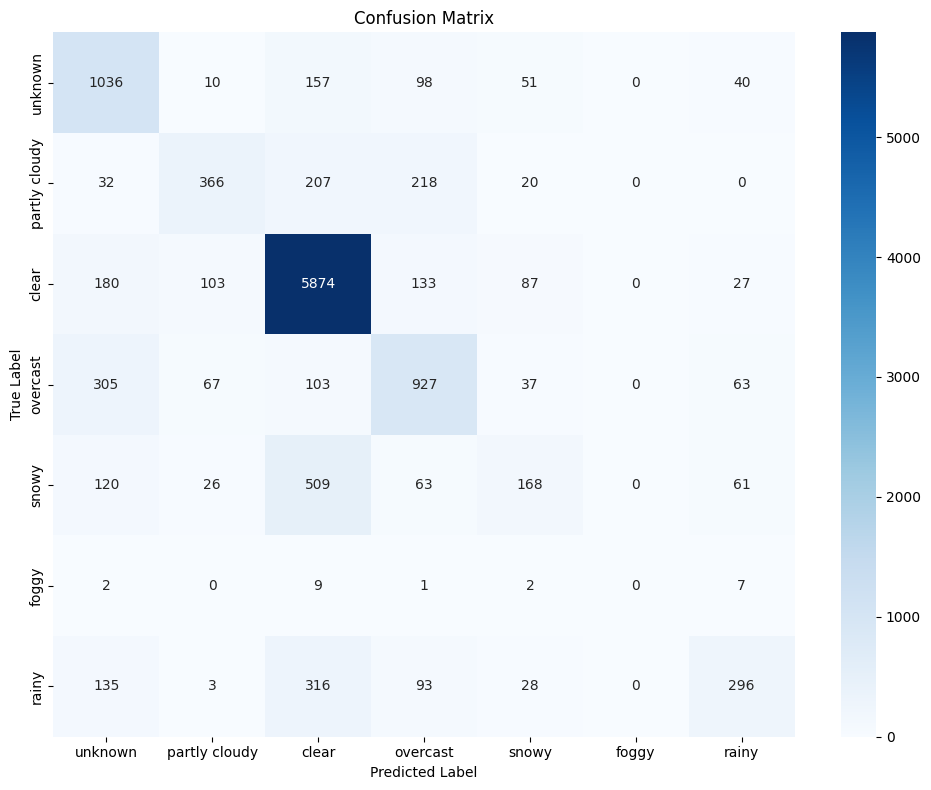

In [6]:
train_loader, val_loader, test_loader,n_classes = get_dataloaders('/kaggle/input/bdd100k/data',128)
model = VisionTransformer(num_classes=n_classes)
train_model(model, train_loader, val_loader)
metrics = evaluate_model(model, test_loader)